In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import geopandas as gpd
import unicodedata
from shapely.affinity import translate, scale
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl


In [2]:
codigos_escolas_distritos = pd.read_parquet("data_parquet/codigos_escolas_distritos.parquet")
escolas = pd.read_parquet("data_parquet/inflacao_escolas_res.parquet")
escolas_anos = pd.read_parquet("data_parquet/inflacao_escolas_anos_res.parquet")
disciplina = pd.read_parquet("data_parquet/inflacao_disciplina_res.parquet")
disciplina_anos = pd.read_parquet("data_parquet/inflacao_disciplina_anos_res.parquet")


In [3]:
codigos_escolas_distritos.head()
#escolas.head()

,escola,escola_descr,escola_distrito,escola_distrito_descr,escola_concelho,escola_concelho_descr,escola_pubpriv
0,2,Escola BÃ¡sica e SecundÃ¡ria de Michel Giacome...,15.0,SetÃºbal,11.0,Sesimbra,PUB
1,31,Escola BÃ¡sica e SecundÃ¡ria Dr. JoÃ£o Brito C...,2.0,Beja,2.0,AlmodÃ´var,PUB
2,39,Escola BÃ¡sica e SecundÃ¡ria de Ourique,2.0,Beja,12.0,Ourique,PUB
3,47,Escola BÃ¡sica e SecundÃ¡ria de Cabeceiras de ...,3.0,Braga,4.0,Cabeceiras de Basto,PUB
4,49,Escola BÃ¡sica e SecundÃ¡ria de Celorico de Basto,3.0,Braga,5.0,Celorico de Basto,PUB


# Useful functions

In [4]:
def mean_and_standard_deviation_from_samples(means, stdevs, nsamples):
    N = np.sum(nsamples)
    mean = np.sum(means * nsamples) / N
    variance = 1/(N-1)*(np.sum(nsamples * (stdevs**2 + means**2))-np.sum(stdevs**2) - N*mean**2)
    return mean, np.sqrt(variance)

def agg_func(group):
    mean, std = mean_and_standard_deviation_from_samples(group["INF_RESIDUAL"], group["INF_RESIDUAL_STD"], group["NSAMPLES"])
    return pd.Series({"INF_RESIDUAL": mean, "INF_RESIDUAL_STD": std, "NSAMPLES": np.sum(group["NSAMPLES"])})

def normalize_name(s):
    if pd.isna(s):
        return s
    s = str(s)

    s = unicodedata.normalize("NFKD", s).encode("ASCII", "ignore").decode("ascii")
    return s.upper().strip()

def pull_toward_center_then_zoom(gdf_4326, alpha=0.5, zoom=2.5):
    """
    alpha in [0,1]: 0 = no move, 1 = collapse to centroid.
    """
    g = gdf_4326.to_crs(3763).copy()
    # explode so we can move each island separately (MultiPolygon -> Polygons)
    g = g.explode(index_parts=False, ignore_index=True)
    center = g.dissolve().geometry.iloc[0].centroid
    cx, cy = center.x, center.y

    def move_piece(geom):
        ci = geom.centroid
        dx = (cx - ci.x) * alpha
        dy = (cy - ci.y) * alpha
        return translate(geom, xoff=dx, yoff=dy)

    # 1) reduce gaps by translating each piece toward the center
    g["geometry"] = g.geometry.apply(move_piece)

    # 2) zoom whole set to fill inset
    g["geometry"] = g.geometry.apply(lambda geom: translate(geom, xoff=-cx, yoff=-cy))
    g["geometry"] = g.geometry.apply(lambda geom: scale(geom, xfact=zoom, yfact=zoom, origin=(0,0)))
    g["geometry"] = g.geometry.apply(lambda geom: translate(geom, xoff=cx, yoff=cy))

    return g.to_crs(4326)

# 1 - Públicas vs Privadas

In [5]:
# add PUB PRIV to set using codigos

escolas_det = escolas.merge(codigos_escolas_distritos, left_on="ESCOLA", right_on="escola", how="left", validate="one_to_one")

In [6]:
escolas_det.head()

,ESCOLA,INF_RESIDUAL,INF_RESIDUAL_STD,NSAMPLES,escola,escola_descr,escola_distrito,escola_distrito_descr,escola_concelho,escola_concelho_descr,escola_pubpriv
0,2,-3.080329,16.913103,2034,2,Escola BÃ¡sica e SecundÃ¡ria de Michel Giacome...,15.0,SetÃºbal,11.0,Sesimbra,PUB
1,31,3.827758,19.778374,439,31,Escola BÃ¡sica e SecundÃ¡ria Dr. JoÃ£o Brito C...,2.0,Beja,2.0,AlmodÃ´var,PUB
2,39,-2.008154,17.876929,361,39,Escola BÃ¡sica e SecundÃ¡ria de Ourique,2.0,Beja,12.0,Ourique,PUB
3,47,8.043103,18.703086,667,47,Escola BÃ¡sica e SecundÃ¡ria de Cabeceiras de ...,3.0,Braga,4.0,Cabeceiras de Basto,PUB
4,49,1.445145,17.521364,1883,49,Escola BÃ¡sica e SecundÃ¡ria de Celorico de Basto,3.0,Braga,5.0,Celorico de Basto,PUB


In [7]:
inflacao_pub_means = escolas_det.loc[escolas_det["escola_pubpriv"] == "PUB", "INF_RESIDUAL"]
inflacao_pub_stdevs = escolas_det.loc[escolas_det["escola_pubpriv"] == "PUB", "INF_RESIDUAL_STD"]
inflacao_pub_nsamples = escolas_det.loc[escolas_det["escola_pubpriv"] == "PUB", "NSAMPLES"]
inflacao_pub_mean, inflacao_pub_std = mean_and_standard_deviation_from_samples(inflacao_pub_means, inflacao_pub_stdevs, inflacao_pub_nsamples)

inflacao_priv_means = escolas_det.loc[escolas_det["escola_pubpriv"] == "PRI", "INF_RESIDUAL"]
inflacao_priv_stdevs = escolas_det.loc[escolas_det["escola_pubpriv"] == "PRI", "INF_RESIDUAL_STD"]
inflacao_priv_nsamples = escolas_det.loc[escolas_det["escola_pubpriv"] == "PRI", "NSAMPLES"]

inflacao_priv_mean, inflacao_priv_std = mean_and_standard_deviation_from_samples(inflacao_priv_means, inflacao_priv_stdevs, inflacao_priv_nsamples)

print("Inflacao escolas publicas: ", inflacao_pub_mean, inflacao_pub_std)
print("Inflacao escolas privadas: ", inflacao_priv_mean, inflacao_priv_std)

Inflacao escolas publicas:  -0.6724808281938631 18.75616048954269
Inflacao escolas privadas:  4.7612887948791744 19.69513449991927


# Inflação por escola

## Histograma, tipo Renascença 

### Mas sem Simpson's paradox

Número de escolas públicas:  524
Número de escolas privadas:  148
Número de bins para escolas públicas:  20
Número de bins para escolas privadas:  10


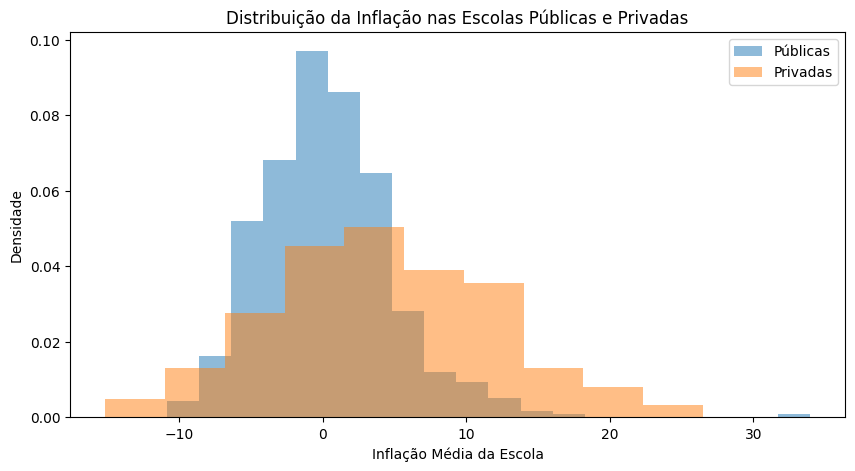

In [8]:
inflacao_pub_means = escolas_det.loc[escolas_det["escola_pubpriv"] == "PUB", "INF_RESIDUAL"]
inflacao_priv_means = escolas_det.loc[escolas_det["escola_pubpriv"] == "PRI", "INF_RESIDUAL"]

num_escolas_publicas = len(inflacao_pub_means)
num_escolas_privadas = len(inflacao_priv_means)

bin_width_pub = 1/np.sqrt(num_escolas_publicas)
bin_width_priv = 1/np.sqrt(num_escolas_privadas)
bins_pub = int((inflacao_pub_means.max() - inflacao_pub_means.min()) / bin_width_pub / 50)
bins_priv = int((inflacao_priv_means.max() - inflacao_priv_means.min()) / bin_width_priv / 50)

print("Número de escolas públicas: ", num_escolas_publicas)
print("Número de escolas privadas: ", num_escolas_privadas)
print("Número de bins para escolas públicas: ", bins_pub)
print("Número de bins para escolas privadas: ", bins_priv)

## Plot histogramas
plt.figure(figsize=(10, 5))
plt.hist(inflacao_pub_means, bins=bins_pub, alpha=0.5, label='Públicas', density=True)
plt.hist(inflacao_priv_means, bins=bins_priv, alpha=0.5, label='Privadas', density=True)
plt.xlabel("Inflação Média da Escola")
plt.ylabel("Densidade")
plt.title("Distribuição da Inflação nas Escolas Públicas e Privadas")
plt.legend()

## Distritos, concelhos

In [23]:
district_stats = escolas_det.groupby(["escola_distrito", "escola_distrito_descr"], observed=True).apply(agg_func).reset_index()
council_stats = escolas_det.groupby(["escola_concelho", "escola_concelho_descr", "escola_distrito"], observed=True).apply(agg_func).reset_index()

district_pubpriv_stats = escolas_det.groupby(["escola_distrito", "escola_pubpriv", "escola_distrito_descr"], observed=True).apply(agg_func).reset_index()
council_pubpriv_stats = escolas_det.groupby(["escola_concelho", "escola_pubpriv", "escola_concelho_descr", "escola_distrito"], observed=True).apply(agg_func).reset_index()


In [24]:
council_stats[council_stats["escola_distrito"] == 13].sort_values(by="INF_RESIDUAL")
council_pubpriv_stats[(council_pubpriv_stats["escola_distrito"] == 13)].sort_values(by="INF_RESIDUAL")

,escola_concelho,escola_pubpriv,escola_concelho_descr,escola_distrito,INF_RESIDUAL,INF_RESIDUAL_STD,NSAMPLES
319,18.0,PUB,Trofa,13.0,-4.196584,19.363599,3485.0
258,13.0,PUB,PÃ³voa de Varzim,13.0,-2.484049,18.424076,11435.0
162,8.0,PUB,Matosinhos,13.0,-2.313305,18.446597,16049.0
120,6.0,PUB,Maia,13.0,-0.382299,18.770240,14778.0
184,9.0,PUB,PaÃ§os de Ferreira,13.0,-0.330530,18.738385,7858.0
33,2.0,PUB,BaiÃ£o,13.0,0.074314,18.893872,1684.0
203,10.0,PUB,Paredes,13.0,0.112810,19.054743,9785.0
101,5.0,PUB,Lousada,13.0,0.150059,18.158112,6531.0
308,16.0,PUB,Vila do Conde,13.0,0.172264,18.032895,8218.0
241,12.0,PUB,Porto,13.0,0.811667,19.051179,25645.0


### Let's try to put it on the map

In [25]:
gdf = gpd.read_file("data_geo/Continente_CAOP2024_1.gpkg", layer="cont_distritos")
print(gdf.columns)

az_oci = gpd.read_file("data_geo/ArqAcores_GOcidental_CAOP2024_1.gpkg", layer="raa_oci_distritos").to_crs(4326)
az_cen = gpd.read_file("data_geo/ArqAcores_GCentral_GOriental_CAOP2024_1.gpkg", layer="raa_cen_ori_distritos").to_crs(4326)
azores = pd.concat([az_oci, az_cen], ignore_index=True)
madeira_ori = gpd.read_file("data_geo/ArqMadeira_CAOP2024_1.gpkg", layer="ram_distritos").to_crs(4326)


district_stats["distrito_norm"] = district_stats["escola_distrito_descr"].apply(normalize_name)
gdf["distrito_norm"] = gdf["distrito"].apply(normalize_name)

#enough to add once
district_stats["distrito_norm"] = district_stats["distrito_norm"].cat.add_categories(["BRAGANCA"])
district_stats["distrito_norm"] = district_stats["distrito_norm"].cat.add_categories(["EVORA"])
district_stats["distrito_norm"] = district_stats["distrito_norm"].cat.add_categories(["SANTAREM"])
district_stats["distrito_norm"] = district_stats["distrito_norm"].cat.add_categories(["SETUBAL"])
district_stats["distrito_norm"] = district_stats["distrito_norm"].cat.add_categories(["R. A. ACORES"])

district_stats.loc[district_stats["distrito_norm"] == "BRAGANAA", "distrito_norm"] = "BRAGANCA"
district_stats.loc[district_stats["distrito_norm"] == "AVORA", "distrito_norm"] = "EVORA"
district_stats.loc[district_stats["distrito_norm"] == "SANTARAM", "distrito_norm"] = "SANTAREM"
district_stats.loc[district_stats["distrito_norm"] == "SETAOBAL", "distrito_norm"] = "SETUBAL"
district_stats.loc[district_stats["distrito_norm"] == "R. A. AAORES", "distrito_norm"] = "R. A. ACORES"

azores = azores.dissolve().assign(distrito_norm="R. A. ACORES")  # match spelling in your stats
az_m = azores.merge(
    district_stats[["distrito_norm", "INF_RESIDUAL"]],
    on="distrito_norm", how="left"
)

madeira = madeira_ori.dissolve().assign(distrito_norm="R. A. MADEIRA")  # match spelling in your stats
md_m = madeira.merge(
    district_stats[["distrito_norm", "INF_RESIDUAL"]],
    on="distrito_norm", how="left"
)

Index(['dt', 'distrito', 'nuts1', 'area_ha', 'perimetro_km', 'n_municipios',
       'n_freguesias', 'geometry'],
      dtype='object')


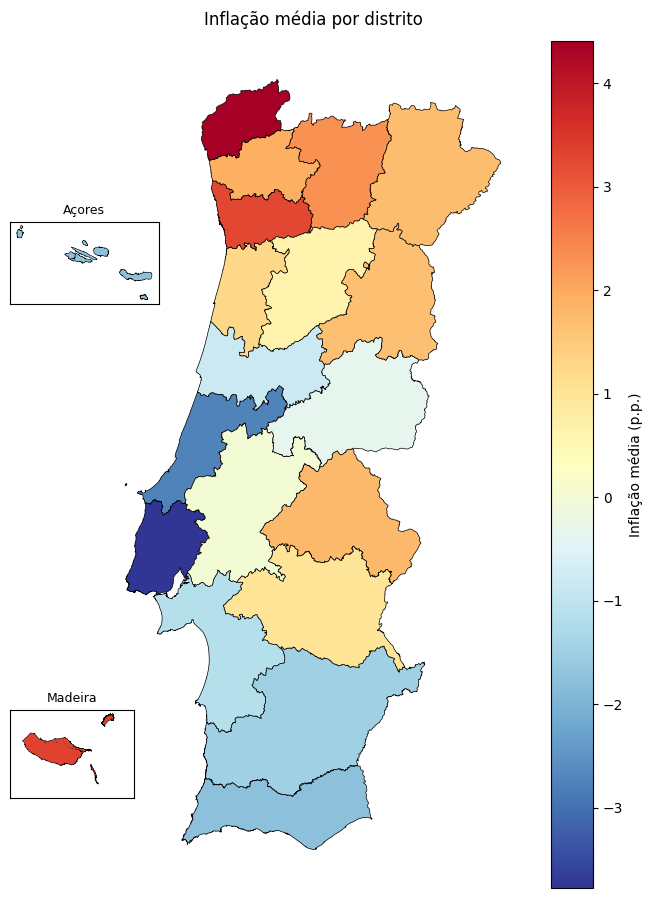

In [26]:
mapdf = gdf.merge(
    district_stats[["distrito_norm", "INF_RESIDUAL"]],
    on="distrito_norm",
    how="left",
    validate="one_to_one"  # check that each district matches uniquely
)

az_distorted = pull_toward_center_then_zoom(az_m, alpha=0.55, zoom=3.0)
md_distorted = pull_toward_center_then_zoom(md_m, alpha=0.30, zoom=2.0)

# 4) back to your plotting CRS (e.g., 4326) to match the mainland/insets
az_distorted = az_distorted.to_crs(4326)
md_distorted = md_distorted.to_crs(4326)

# --- 3) One common color normalization (so colors are comparable) ---
vmin = pd.concat([mapdf["INF_RESIDUAL"], az_m["INF_RESIDUAL"], md_m["INF_RESIDUAL"]]).min()
vmax = pd.concat([mapdf["INF_RESIDUAL"], az_m["INF_RESIDUAL"], md_m["INF_RESIDUAL"]]).max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = "RdYlBu_r"   # pick what you like



# --- 4) Plot: main map + insets ---
fig, ax = plt.subplots(figsize=(20, 11))

# Mainland (big axis)
mapdf.plot(ax=ax, column="INF_RESIDUAL", cmap=cmap, norm=norm,
            edgecolor="black", linewidth=0.5, legend=False,
            missing_kwds={"color":"lightgrey","hatch":"///","label":"Sem dados"})
ax.set_axis_off()
ax.set_title("Inflação média por distrito", pad=12)

# Azores inset (bottom-left; tweak size/loc as needed)
ax_az = inset_axes(
    ax,
    width="30%", height="30%",
    bbox_to_anchor=(-0.25, 0.55, 1.2, 1.2),  # (x0, y0, width, height) in axis coords
    bbox_transform=ax.transAxes,
    loc="lower left"
)
az_distorted.plot(ax=ax_az, column="INF_RESIDUAL", cmap=cmap, norm=norm,
          edgecolor="black", linewidth=0.4, legend=False,
          missing_kwds={"color":"lightgrey","hatch":"///","label":"Sem dados"})
ax_az.set_xticks([]); ax_az.set_yticks([]); ax_az.set_title("Açores", fontsize=9)

# Madeira inset (lower-left, above Azores; tweak position via borderpad or use bbox_to_anchor)
ax_md = inset_axes(
    ax,
    width="20%", height="20%",
    bbox_to_anchor=(-0.25, 0.05, 1.5, 1),
    bbox_transform=ax.transAxes,
    loc="lower left"
)
md_distorted.plot(ax=ax_md, column="INF_RESIDUAL", cmap=cmap, norm=norm,
          edgecolor="black", linewidth=0.4, legend=False,
          missing_kwds={"color":"lightgrey","hatch":"///","label":"Sem dados"})
xmin, ymin, xmax, ymax = md_m.total_bounds
ax_md.set_xlim(xmin-0.5, xmax+0.2)
ax_md.set_ylim(ymin + 0.65*(ymax - ymin), ymax+0.2)   # crop bottom 40% of extent
ax_md.set_xticks([]); ax_md.set_yticks([]); ax_md.set_title("Madeira", fontsize=9)

# --- 5) Single shared colorbar ---
# Create a dummy mappable to attach a colorbar with the same cmap/norm

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Inflação média (p.p.)")

#plt.tight_layout()
plt.show()

#### Other variables

In [27]:
district_pubpriv_stats["distrito_norm"] = district_pubpriv_stats["escola_distrito_descr"].apply(normalize_name)

district_pubpriv_stats["distrito_norm"] = district_pubpriv_stats["distrito_norm"].cat.add_categories(["BRAGANCA"])
district_pubpriv_stats["distrito_norm"] = district_pubpriv_stats["distrito_norm"].cat.add_categories(["EVORA"])
district_pubpriv_stats["distrito_norm"] = district_pubpriv_stats["distrito_norm"].cat.add_categories(["SANTAREM"])
district_pubpriv_stats["distrito_norm"] = district_pubpriv_stats["distrito_norm"].cat.add_categories(["SETUBAL"])
district_pubpriv_stats["distrito_norm"] = district_pubpriv_stats["distrito_norm"].cat.add_categories(["R. A. ACORES"])

district_pubpriv_stats.loc[district_pubpriv_stats["distrito_norm"] == "BRAGANAA", "distrito_norm"] = "BRAGANCA"
district_pubpriv_stats.loc[district_pubpriv_stats["distrito_norm"] == "AVORA", "distrito_norm"] = "EVORA"
district_pubpriv_stats.loc[district_pubpriv_stats["distrito_norm"] == "SANTARAM", "distrito_norm"] = "SANTAREM"
district_pubpriv_stats.loc[district_pubpriv_stats["distrito_norm"] == "SETAOBAL", "distrito_norm"] = "SETUBAL"
district_pubpriv_stats.loc[district_pubpriv_stats["distrito_norm"] == "R. A. AAORES", "distrito_norm"] = "R. A. ACORES"

In [ ]:
wide = (district_pubpriv_stats
        .pivot(index="escola_distrito", columns="escola_pubpriv", values="INF_RESIDUAL")
        .rename(columns={"PUB":"INF_RESIDUAL_PUB", "PRI":"INF_RESIDUAL_PRI"})
        .reset_index())

district_stats = district_stats.merge(wide, on="escola_distrito", how="left")
district_stats["INF_RESIDUAL_DIFF"] = district_stats["INF_RESIDUAL_PRI"] - district_stats["INF_RESIDUAL_PUB"]

In [37]:
district_stats

,escola_distrito,escola_distrito_descr,INF_RESIDUAL,INF_RESIDUAL_STD,NSAMPLES,distrito_norm,INF_RESIDUAL_PRI,INF_RESIDUAL_PUB,INF_RESIDUAL_DIFF
0,1.0,Aveiro,1.260501,18.415620,94546.0,AVEIRO,4.398944,0.871013,3.527930
1,2.0,Beja,-1.487053,18.250463,14489.0,BEJA,0.504448,-1.589518,2.093966
2,3.0,Braga,1.916455,19.111115,122386.0,BRAGA,7.327776,0.957530,6.370246
3,4.0,BraganÃ§a,1.711366,19.364610,14454.0,BRAGANCA,-2.517840,1.816009,-4.333849
4,5.0,Castelo Branco,-0.354028,18.083966,20700.0,CASTELO BRANCO,-0.252838,-0.358271,0.105433
5,6.0,Coimbra,-0.829805,18.268316,54513.0,COIMBRA,4.944728,-1.652647,6.597374
6,7.0,Ãvora,1.043622,18.345973,23670.0,EVORA,11.651732,0.914338,10.737395
7,8.0,Faro,-1.789520,18.797193,49395.0,FARO,3.356885,-1.864359,5.221244
8,9.0,Guarda,1.672786,18.939510,18602.0,GUARDA,12.681120,1.665088,11.016033
9,10.0,Leiria,-2.733872,17.801418,59329.0,LEIRIA,-4.134851,-2.498560,-1.636291


In [34]:
mapdf_completo = gdf.merge(
    district_stats[["distrito_norm", "INF_RESIDUAL", "INF_RESIDUAL_PUB", "INF_RESIDUAL_PRI", "INF_RESIDUAL_DIFF"]],
    on="distrito_norm",
    how="left",
    validate="one_to_one"  # check that each district matches uniquely
)

az_m_completo = azores.merge(
    district_stats[["distrito_norm", "INF_RESIDUAL", "INF_RESIDUAL_PUB", "INF_RESIDUAL_PRI", "INF_RESIDUAL_DIFF"]],
    on="distrito_norm", how="left"
)

md_m_completo = madeira.merge(
    district_stats[["distrito_norm", "INF_RESIDUAL", "INF_RESIDUAL_PUB", "INF_RESIDUAL_PRI", "INF_RESIDUAL_DIFF"]],
    on="distrito_norm", how="left"
)

In [35]:
az_distorted = pull_toward_center_then_zoom(az_m_completo, alpha=0.55, zoom=3.0)
md_distorted = pull_toward_center_then_zoom(md_m_completo, alpha=0.30, zoom=2.0)

# 4) back to your plotting CRS (e.g., 4326) to match the mainland/insets
az_distorted = az_distorted.to_crs(4326)
md_distorted = md_distorted.to_crs(4326)

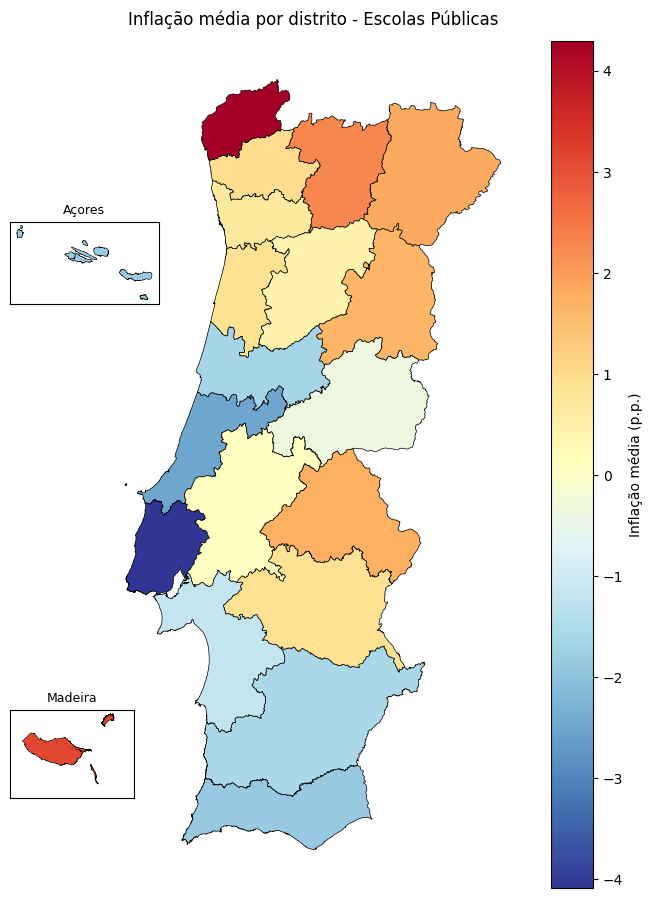

In [36]:
# --- 3) One common color normalization (so colors are comparable) ---
vmin = pd.concat([mapdf_completo["INF_RESIDUAL_PUB"], az_m_completo["INF_RESIDUAL_PUB"], md_m_completo["INF_RESIDUAL_PUB"]]).min()
vmax = pd.concat([mapdf_completo["INF_RESIDUAL_PUB"], az_m_completo["INF_RESIDUAL_PUB"], md_m_completo["INF_RESIDUAL_PUB"]]).max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = "RdYlBu_r"   # pick what you like



# --- 4) Plot: main map + insets ---
fig, ax = plt.subplots(figsize=(20, 11))

# Mainland (big axis)
mapdf_completo.plot(ax=ax, column="INF_RESIDUAL_PUB", cmap=cmap, norm=norm,
            edgecolor="black", linewidth=0.5, legend=False,
            missing_kwds={"color":"lightgrey","hatch":"///","label":"Sem dados"})
ax.set_axis_off()
ax.set_title("Inflação média por distrito - Escolas Públicas", pad=12)

# Azores inset (bottom-left; tweak size/loc as needed)
ax_az = inset_axes(
    ax,
    width="30%", height="30%",
    bbox_to_anchor=(-0.25, 0.55, 1.2, 1.2),  # (x0, y0, width, height) in axis coords
    bbox_transform=ax.transAxes,
    loc="lower left"
)
az_distorted.plot(ax=ax_az, column="INF_RESIDUAL_PUB", cmap=cmap, norm=norm,
          edgecolor="black", linewidth=0.4, legend=False,
          missing_kwds={"color":"lightgrey","hatch":"///","label":"Sem dados"})
ax_az.set_xticks([]); ax_az.set_yticks([]); ax_az.set_title("Açores", fontsize=9)

# Madeira inset (lower-left, above Azores; tweak position via borderpad or use bbox_to_anchor)
ax_md = inset_axes(
    ax,
    width="20%", height="20%",
    bbox_to_anchor=(-0.25, 0.05, 1.5, 1),
    bbox_transform=ax.transAxes,
    loc="lower left"
)
md_distorted.plot(ax=ax_md, column="INF_RESIDUAL_PUB", cmap=cmap, norm=norm,
          edgecolor="black", linewidth=0.4, legend=False,
          missing_kwds={"color":"lightgrey","hatch":"///","label":"Sem dados"})
xmin, ymin, xmax, ymax = md_m.total_bounds
ax_md.set_xlim(xmin-0.5, xmax+0.2)
ax_md.set_ylim(ymin + 0.65*(ymax - ymin), ymax+0.2)   # crop bottom 40% of extent
ax_md.set_xticks([]); ax_md.set_yticks([]); ax_md.set_title("Madeira", fontsize=9)

# --- 5) Single shared colorbar ---
# Create a dummy mappable to attach a colorbar with the same cmap/norm

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Inflação média (p.p.)")

#plt.tight_layout()
plt.show()

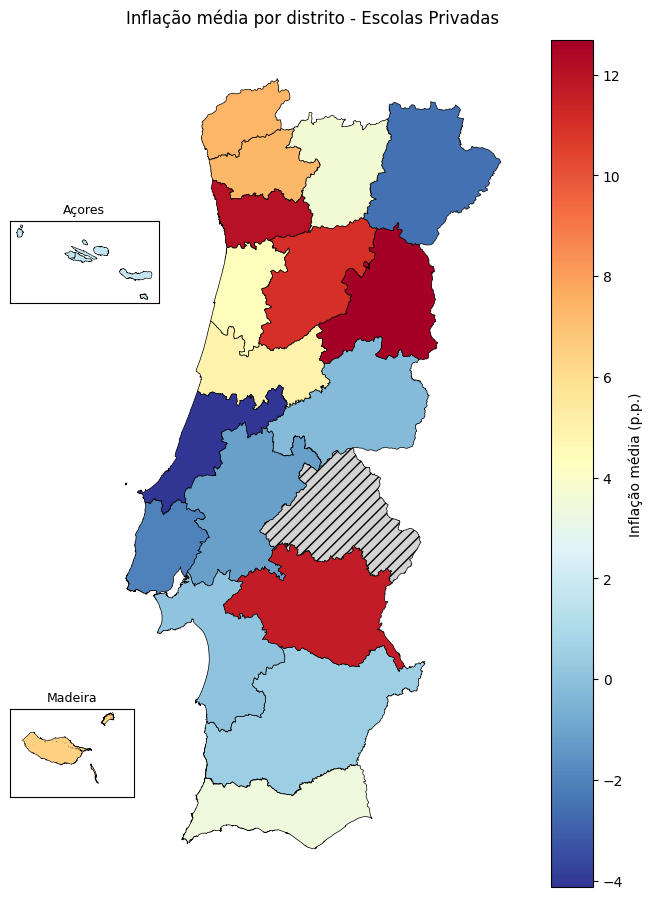

In [38]:
# --- 3) One common color normalization (so colors are comparable) ---
vmin = pd.concat([mapdf_completo["INF_RESIDUAL_PRI"], az_m_completo["INF_RESIDUAL_PRI"], md_m_completo["INF_RESIDUAL_PRI"]]).min()
vmax = pd.concat([mapdf_completo["INF_RESIDUAL_PRI"], az_m_completo["INF_RESIDUAL_PRI"], md_m_completo["INF_RESIDUAL_PRI"]]).max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = "RdYlBu_r"   # pick what you like



# --- 4) Plot: main map + insets ---
fig, ax = plt.subplots(figsize=(20, 11))

# Mainland (big axis)
mapdf_completo.plot(ax=ax, column="INF_RESIDUAL_PRI", cmap=cmap, norm=norm,
            edgecolor="black", linewidth=0.5, legend=False,
            missing_kwds={"color":"lightgrey","hatch":"///","label":"Sem dados"})
ax.set_axis_off()
ax.set_title("Inflação média por distrito - Escolas Privadas", pad=12)

# Azores inset (bottom-left; tweak size/loc as needed)
ax_az = inset_axes(
    ax,
    width="30%", height="30%",
    bbox_to_anchor=(-0.25, 0.55, 1.2, 1.2),  # (x0, y0, width, height) in axis coords
    bbox_transform=ax.transAxes,
    loc="lower left"
)
az_distorted.plot(ax=ax_az, column="INF_RESIDUAL_PRI", cmap=cmap, norm=norm,
          edgecolor="black", linewidth=0.4, legend=False,
          missing_kwds={"color":"lightgrey","hatch":"///","label":"Sem dados"})
ax_az.set_xticks([]); ax_az.set_yticks([]); ax_az.set_title("Açores", fontsize=9)

# Madeira inset (lower-left, above Azores; tweak position via borderpad or use bbox_to_anchor)
ax_md = inset_axes(
    ax,
    width="20%", height="20%",
    bbox_to_anchor=(-0.25, 0.05, 1.5, 1),
    bbox_transform=ax.transAxes,
    loc="lower left"
)
md_distorted.plot(ax=ax_md, column="INF_RESIDUAL_PRI", cmap=cmap, norm=norm,
          edgecolor="black", linewidth=0.4, legend=False,
          missing_kwds={"color":"lightgrey","hatch":"///","label":"Sem dados"})
xmin, ymin, xmax, ymax = md_m.total_bounds
ax_md.set_xlim(xmin-0.5, xmax+0.2)
ax_md.set_ylim(ymin + 0.65*(ymax - ymin), ymax+0.2)   # crop bottom 40% of extent
ax_md.set_xticks([]); ax_md.set_yticks([]); ax_md.set_title("Madeira", fontsize=9)

# --- 5) Single shared colorbar ---
# Create a dummy mappable to attach a colorbar with the same cmap/norm

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Inflação média (p.p.)")

#plt.tight_layout()
plt.show()

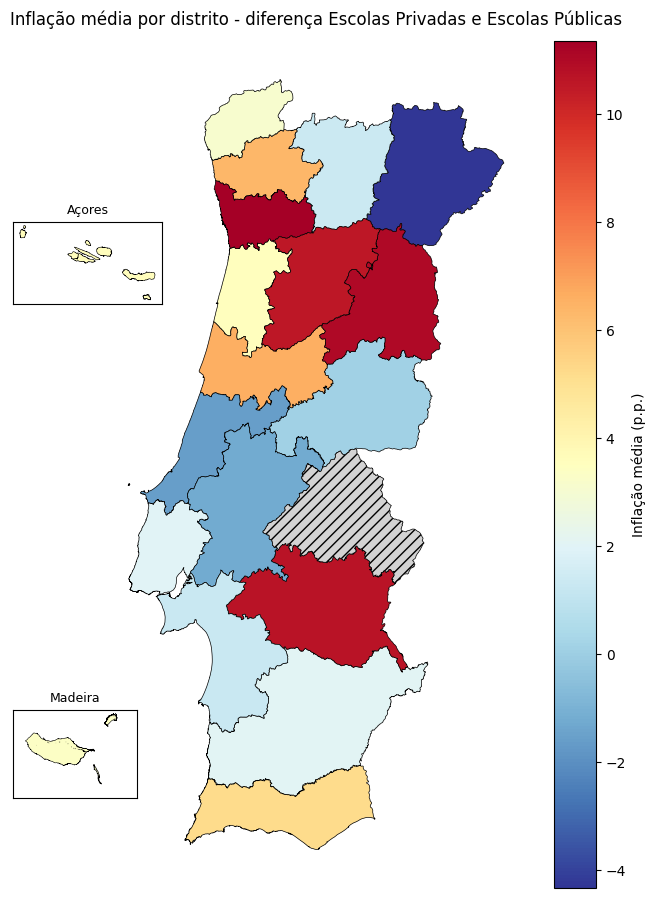

In [39]:
# --- 3) One common color normalization (so colors are comparable) ---
vmin = pd.concat([mapdf_completo["INF_RESIDUAL_DIFF"], az_m_completo["INF_RESIDUAL_DIFF"], md_m_completo["INF_RESIDUAL_DIFF"]]).min()
vmax = pd.concat([mapdf_completo["INF_RESIDUAL_DIFF"], az_m_completo["INF_RESIDUAL_DIFF"], md_m_completo["INF_RESIDUAL_DIFF"]]).max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = "RdYlBu_r"   # pick what you like



# --- 4) Plot: main map + insets ---
fig, ax = plt.subplots(figsize=(20, 11))

# Mainland (big axis)
mapdf_completo.plot(ax=ax, column="INF_RESIDUAL_DIFF", cmap=cmap, norm=norm,
            edgecolor="black", linewidth=0.5, legend=False,
            missing_kwds={"color":"lightgrey","hatch":"///","label":"Sem dados"})
ax.set_axis_off()
ax.set_title("Inflação média por distrito - diferença Escolas Privadas e Escolas Públicas", pad=12)

# Azores inset (bottom-left; tweak size/loc as needed)
ax_az = inset_axes(
    ax,
    width="30%", height="30%",
    bbox_to_anchor=(-0.25, 0.55, 1.2, 1.2),  # (x0, y0, width, height) in axis coords
    bbox_transform=ax.transAxes,
    loc="lower left"
)
az_distorted.plot(ax=ax_az, column="INF_RESIDUAL_DIFF", cmap=cmap, norm=norm,
          edgecolor="black", linewidth=0.4, legend=False,
          missing_kwds={"color":"lightgrey","hatch":"///","label":"Sem dados"})
ax_az.set_xticks([]); ax_az.set_yticks([]); ax_az.set_title("Açores", fontsize=9)

# Madeira inset (lower-left, above Azores; tweak position via borderpad or use bbox_to_anchor)
ax_md = inset_axes(
    ax,
    width="20%", height="20%",
    bbox_to_anchor=(-0.25, 0.05, 1.5, 1),
    bbox_transform=ax.transAxes,
    loc="lower left"
)
md_distorted.plot(ax=ax_md, column="INF_RESIDUAL_DIFF", cmap=cmap, norm=norm,
          edgecolor="black", linewidth=0.4, legend=False,
          missing_kwds={"color":"lightgrey","hatch":"///","label":"Sem dados"})
xmin, ymin, xmax, ymax = md_m.total_bounds
ax_md.set_xlim(xmin-0.5, xmax+0.2)
ax_md.set_ylim(ymin + 0.65*(ymax - ymin), ymax+0.2)   # crop bottom 40% of extent
ax_md.set_xticks([]); ax_md.set_yticks([]); ax_md.set_title("Madeira", fontsize=9)

# --- 5) Single shared colorbar ---
# Create a dummy mappable to attach a colorbar with the same cmap/norm

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Inflação média (p.p.)")

#plt.tight_layout()
plt.show()

## Exploration

In [41]:
district_pubpriv_stats

,escola_distrito,escola_pubpriv,INF_RESIDUAL,INF_RESIDUAL_STD,NSAMPLES
0,1.0,PRI,4.398944,18.249548,10438.0
1,1.0,PUB,0.871013,18.398930,84108.0
2,2.0,PRI,0.504448,17.350548,709.0
3,2.0,PUB,-1.589518,18.290303,13780.0
4,3.0,PRI,7.327776,19.213909,18423.0
5,3.0,PUB,0.957530,18.932286,103963.0
6,4.0,PRI,-2.517840,20.757856,349.0
7,4.0,PUB,1.816009,19.317916,14105.0
8,5.0,PRI,-0.252838,18.495161,833.0
9,5.0,PUB,-0.358271,18.066984,19867.0


In [33]:
#subset = escolas_det[(escolas_det["escola_distrito"] == 11) & (escolas_det["escola_concelho"] == 6)]
subset = escolas_det[(escolas_det["escola_distrito"] == 2)]